# Train Siamese

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [42]:
# train_siamese.py

from datetime import datetime

import tensorflow as tf
import tensorflow_addons as tfa
from absl import app
from tqdm.keras import TqdmCallback

from data.data_generator import DataGenerator
from model.siamese.config import cfg
from model.siamese.model_generator import create_model, base_models

TRAINABLE = True

base_model = list(base_models.keys())[0]  # MobileNetV2

WEIGHTS_DIR = "model/siamese/weights"


#def main(_argv):

model = create_model(trainable=TRAINABLE, base_model=base_model)
prefix = "block3c_add"
try:
    tf.keras.utils.plot_model(
        model,
        to_file=f"assets/{base_model}_model_fig.png",
        show_shapes=True,
        expand_nested=True,
    )
except ImportError as e:
    print(f"Failed to plot keras model: {e}")

ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    folder_path="data/filter_aug/train",
    exclude_aug=True,
    #step_size=4,
    step_size=1
)

# train_ds = ds_generator.get_dataset()

learning_rate = cfg.TRAIN.LEARNING_RATE

# optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
loss_fun = tfa.losses.TripletSemiHardLoss()
model.compile(loss=loss_fun, optimizer=optimizer, metrics=[])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    WEIGHTS_DIR + "/" + base_model + "/siam-{epoch}-"+str(learning_rate)+"-"+str(prefix)+"_{loss:.4f}.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)
# stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=cfg.TRAIN.PATIENCE, mode="min")
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.6, patience=5, min_lr=1e-6, verbose=1,
#                                                  mode="min")

# Define the Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


model.fit(
    ds_generator,
    epochs=cfg.TRAIN.EPOCHS,
    callbacks=[tensorboard_callback, checkpoint, TqdmCallback(verbose=0)],
    verbose=0
)



Found 54 files for 27 unique classes


/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0epoch [00:00, ?epoch/s]

2022-09-08 07:07:43.373796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Generate Siamese Embedded Space

In [43]:
# generate_siamese_emb_space.py

import io
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
from absl import app, flags
from absl.flags import FLAGS

from data.data_generator import DataGenerator
from model.siamese.model_generator import create_model, base_models
from model.siamese.config import cfg

# flags.DEFINE_string(
#     "weights",
#     "siam-118-0.0001-1.0a_0.0633.h5",
#     "weights name",
# )

# flags.DEFINE_string(
#     "datatype",
#     "train",
#     "weights name",
# )
datatype = 'train' #D LISKE
#weights = 'siam-147-0.0001-block3c_add_0.0047.h5' #D LISKE
weights = 'siam-107-0.0001-block3c_add_0.0000.h5'

WEIGHTS_DIR = "model/siamese/weights"

base_model = list(base_models.keys())[0]  # MobileNetV2


### def main(_argv):
model = create_model(base_model=base_model)
# if FLAGS.datatype != "train" and FLAGS.datatype != "test":
#     FLAGS.datatype = "train"

if datatype != "train" and datatype != "test":
    datatype = "train"


#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{FLAGS.weights}")
model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{weights}")


ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    #folder_path=f"data/filter_aug/{FLAGS.datatype}",
    folder_path=f"data/filter_aug/{datatype}",
    exclude_aug=True,
    step_size=1,
)

dataset = ds_generator.get_dataset()

results = model.predict(dataset)

# save pure results (embedding) and create meta mapping for each row (visualization files)
#np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
#out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
for img, labels in tfds.as_numpy(dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

# merge all embeddings per class
per_class = {}
idx = 0
for img, labels in tfds.as_numpy(dataset):
    for class_id in labels:
        if class_id not in per_class:
            per_class[class_id] = []
        per_class[class_id].append(results[idx])
        idx += 1

mean_values = None
labels = None
# calculate average value for each class
for class_id, values in per_class.items():
    #print("CLASS_ID", class_id)#, values)
    matrix = np.array(values)
    mean_val = np.mean(matrix, axis=0)
    if mean_values is None:
        mean_values = np.array([mean_val])
    else:
        mean_values = np.concatenate((mean_values, np.array([mean_val])), axis=0)
    if labels is None:
        labels = np.array([class_id], dtype='U20')
    else:
        labels = np.concatenate((labels, [class_id]), axis=0, dtype='U20')

# save avg embedding per class to be used as visualization and for further processing
np.savetxt(f"vecs-conc-{base_model}.tsv", mean_values, delimiter="\t")
#np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%i", delimiter="\t")
np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%s", delimiter="\t") #D LISKE
# np.savetxt(
#     f"emb_space.csv", np.concatenate((mean_values, labels), axis=1), delimiter="\t"
# )



Found 54 files for 27 unique classes


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 1311.51it/s]
2022-09-08 07:09:07.816767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 342ms/step


# Test Siamese

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 54 files for 27 unique classes


100%|███████████████████████████████████████████| 54/54 [00:02<00:00, 34.40it/s]/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/debbieliske/miniforge3/envs/dog/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

,precision,recall,f1-score,support
Chinnar 6 Male,0.50,1.00,0.67,2.00
Chinnar 1 Male,0.50,1.00,0.67,2.00
Chinnar 10 Male,0.00,0.00,0.00,2.00
Chinnar 11 Male,0.50,1.00,0.67,2.00
Chinnar 12 Juvenile,0.00,0.00,0.00,2.00
Chinnar 13 Female,1.00,1.00,1.00,2.00
Chinnar 14 Female,1.00,1.00,1.00,2.00
Chinnar 15 Female,1.00,1.00,1.00,2.00
Chinnar 16 Male,1.00,1.00,1.00,2.00
Chinnar 17 Male,0.00,0.00,0.00,2.00


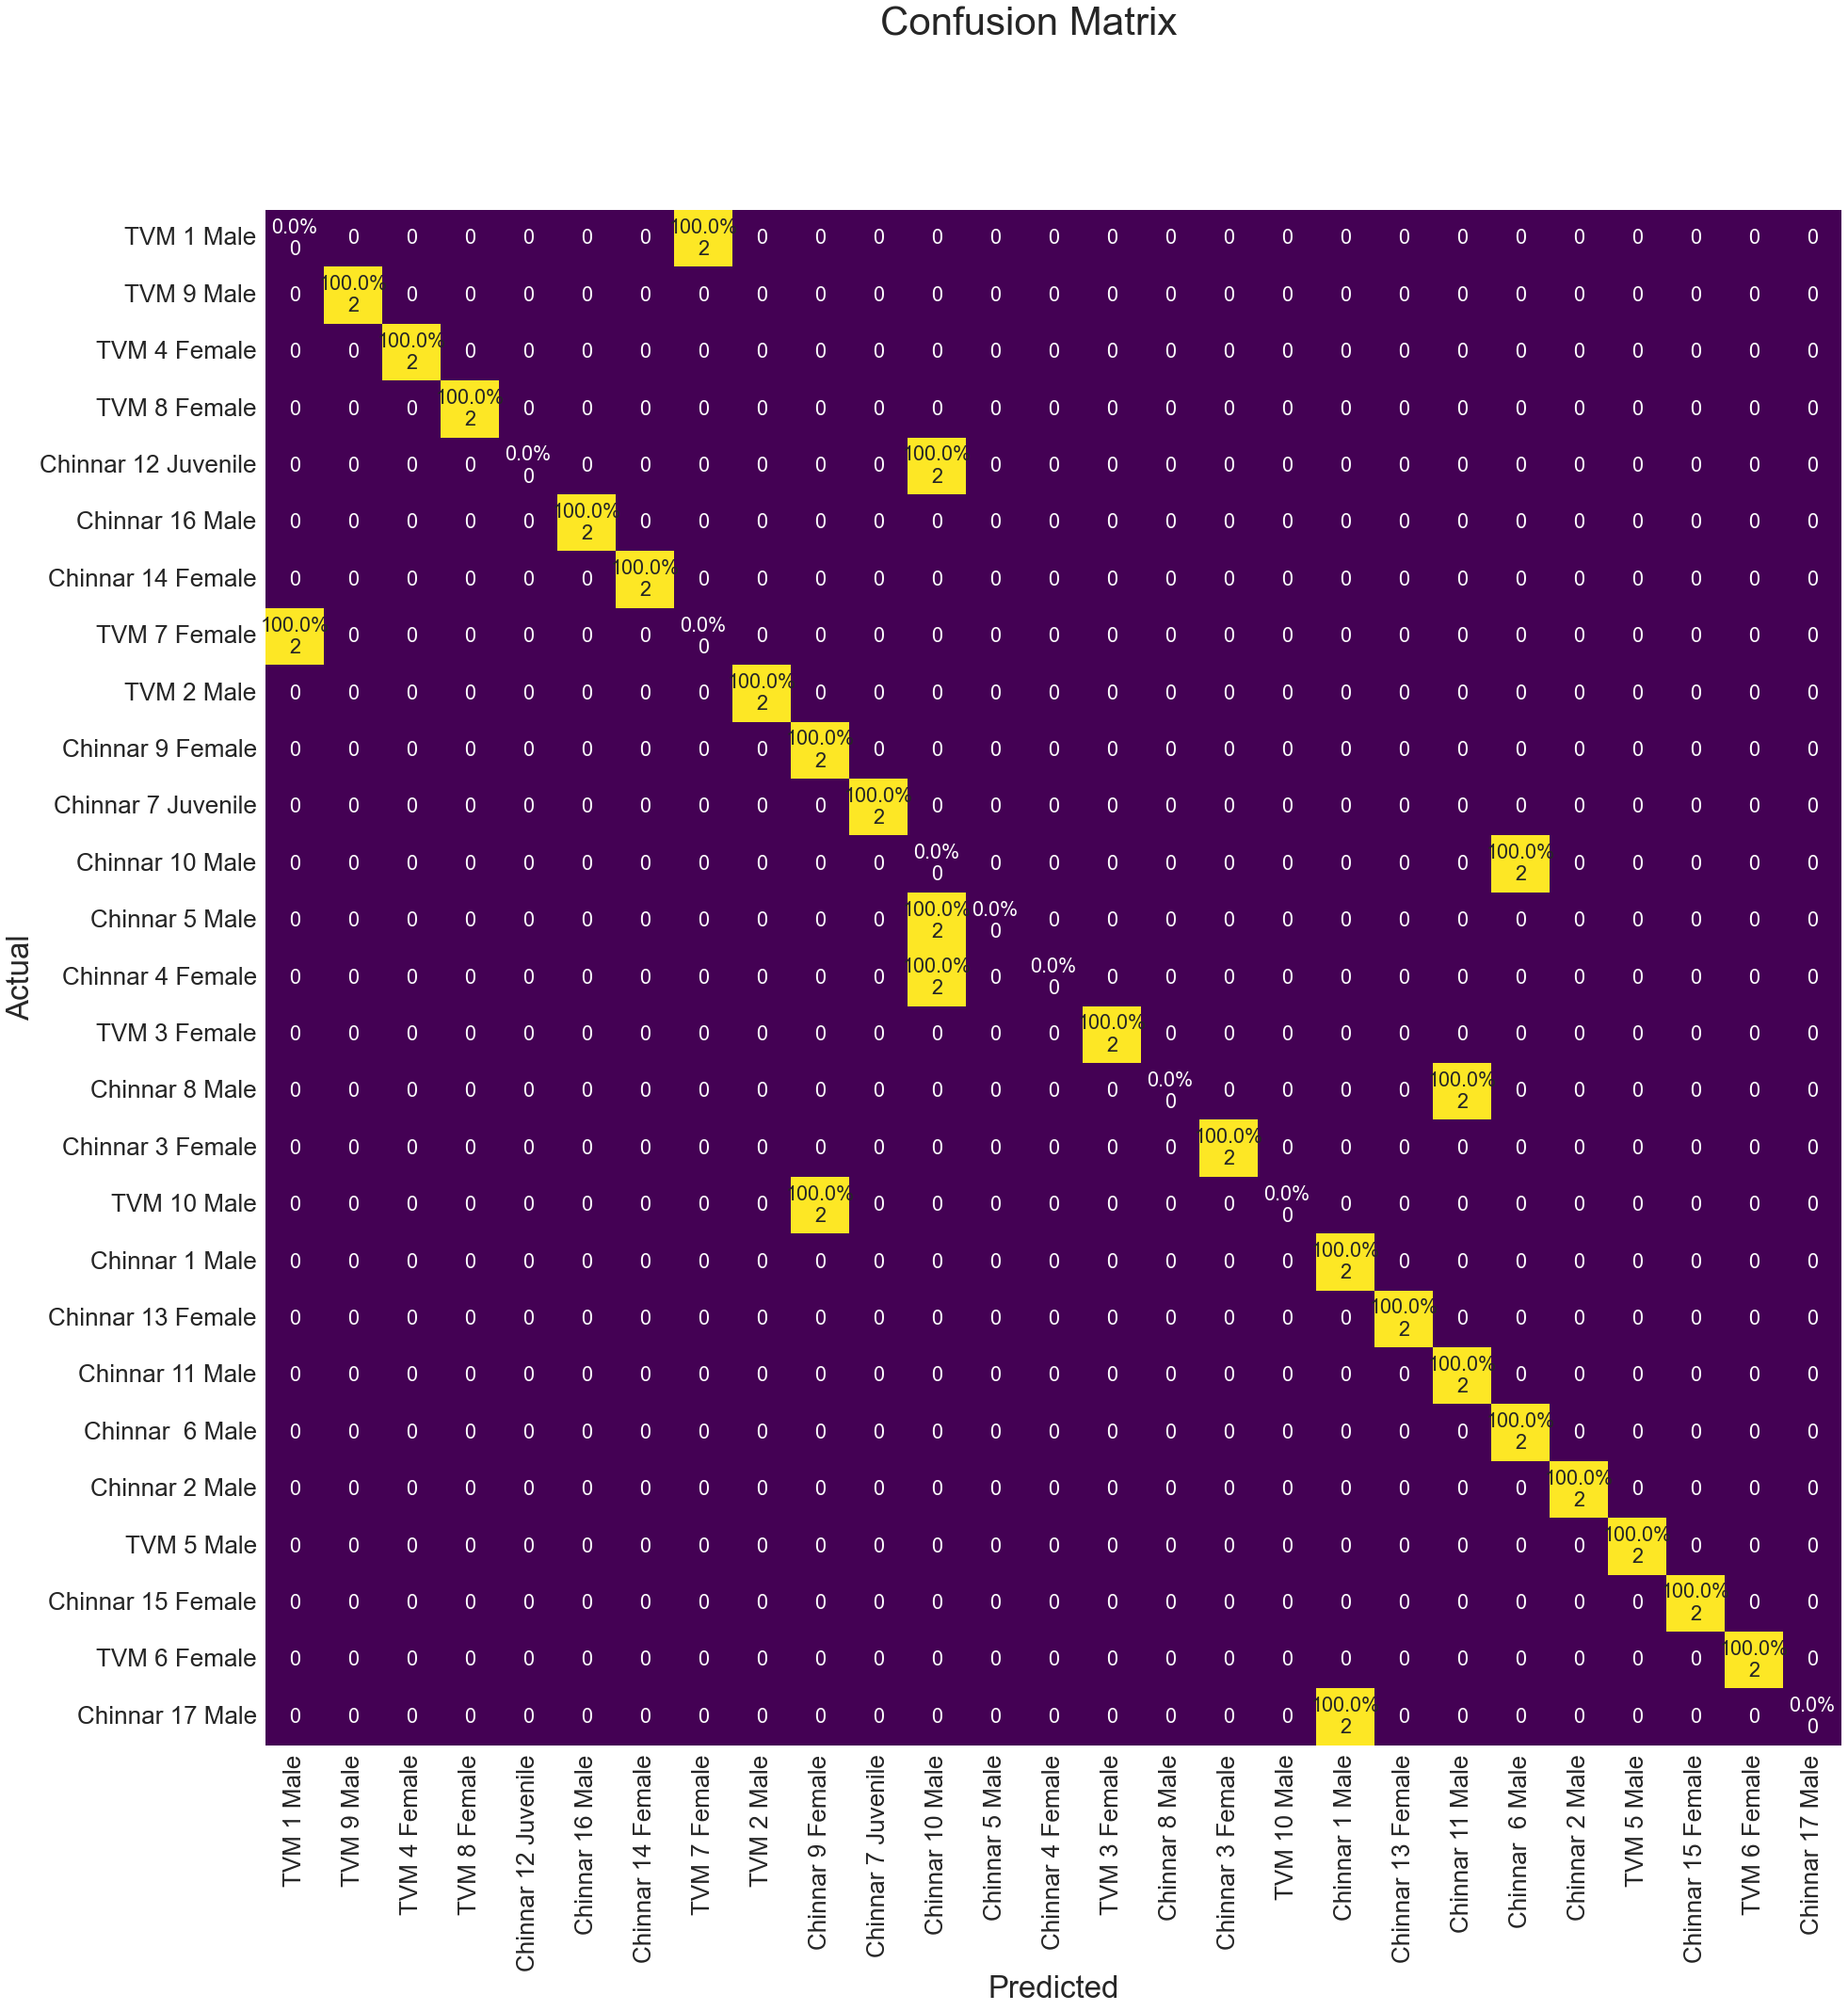

In [45]:
# test_siamese.py

%load_ext autoreload
%autoreload 2

import time

import numpy as np
import os
import datetime
from absl import app, flags
from absl.flags import FLAGS

from data.data_generator import DataGenerator
from data.names import names
from helpers.score_processing import cm_analysis, classification_report_latex
from model.siamese.model_generator import create_model, base_models
from model.siamese.config import cfg
from data.siamese_evaluator import SiameseEvaluator


# flags.DEFINE_string(
#     "weights",
#     "siam-147-0.001-block3c_add_0.2488.h5",
#     "weights name",
# )

# flags.DEFINE_string(
#     "datatype",
#     "train",
#     "weights name",
# )

# flags.DEFINE_string(
#     "vectors",
#     "model/siamese/vectors/vecs-conc-EfficientNetB5.tsv",
#     "path to vectors tsv",
# )

# flags.DEFINE_string(
#     "meta",
#     "model/siamese/vectors/meta-conc-EfficientNetB5.tsv",
#     "path to meta tsv",
# )

WEIGHTS_DIR = "model/siamese/weights"
weights = 'siam-107-0.0001-block3c_add_0.0000.h5' # DLiske
vectors = 'vecs-conc-MobileNetV2.tsv' # DLiske
meta = 'meta-conc-MobileNetV2.tsv'  # DLiske

base_model = list(base_models.keys())[0]  # MobileNetV2
# flags.DEFINE_string('target', './crop_images/5.jpg', 'path to input image')
# flags.DEFINE_string('source', './crop_images/1.jpg', 'path to input image')


def generate_test_dir(basemodel):
    test_dir = os.path.join(
        "experiments", "siamese", basemodel
    )

    if not os.path.isdir(test_dir):
        os.mkdir(test_dir)

    out_dir = os.path.join(
        test_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    )

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    return out_dir


#def main(_argv):
out_dir = generate_test_dir(base_model)

model = create_model(base_model=base_model)
#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{FLAGS.weights}")
model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{weights}")
ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    folder_path=f"data/filter_aug/test",
    exclude_aug=True,
    step_size=1,
)

# images = ds_generator.__getitem__(1)
# print(images[0].shape)
# print(images[1])
evaluator = SiameseEvaluator(model=model, dataset=ds_generator.org_images)
#evaluator.set_avg_vectors(FLAGS.vectors, FLAGS.meta)
evaluator.set_avg_vectors(vectors, meta)
conf_matrix, class_report = evaluator.run_evaluation(compare_type="individual")
display(pd.DataFrame(class_report).transpose().round(2))
cm_analysis(conf_matrix, names, filename=os.path.join(out_dir, f"conf_matrix_{base_model}.png"))
#classification_report_latex(class_report, filename=os.path.join(out_dir, f"class_report_{base_model}.txt"))

